In [2]:
%matplotlib widget
import sys

from torch.autograd import Variable

import torchattacks
from demo.utils import imshow, get_pred
sys.path.insert(0, '..')
import robustbench
from robustbench.data import load_cifar10, load_imagenetc
from robustbench.utils import load_model, clean_accuracy
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import PIL

from decimal import Decimal

def image_folder_custom_label(root, transform, idx2label, idex2name):
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

    old_data = dsets.ImageFolder(root=root, transform=transform)
    old_classes = old_data.classes

    label2idx = {}

    for i, item in enumerate(idx2label):
        label2idx[item] = i

    new_data = dsets.ImageFolder(root=root, transform=transform,
                                 target_transform=lambda x: idex2name.index(old_classes[x]))
    # target_transform 的作用是将target转换成target的index，进而在getitem中将target转换成one-hot
    new_data.targets = [idex2name.index(new_data.classes[k]) for k in range(len(new_data.classes))]
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

def get_imagenet_data(n_examples): # n_examples是要取的数据的个数
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    # https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
    class_idx = json.load(open("./data/imagenet_class_index.json"))
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    idx2name = [class_idx[str(k)][0] for k in range(len(class_idx))]
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])

    imagnet_data = image_folder_custom_label(root='./data/val',
                                             transform=transform,
                                             idx2label=idx2label,
                                             idex2name=idx2name)
    data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=1, shuffle=False)
    # torch.utils.data.DataLoader的作用是将数据集封装成一个batch_size大小的Tensor，用于后续的训练
    x_test, y_test = [], []
    for step, (x, y) in enumerate(data_loader):
        # step是enumerate的索引，x是data_loader中的数据，y是data_loader中的标签
        x_test.append(x)
        y_test.append(y)
        if n_examples is not None and n_examples-1<=step:
            # n_examples-1<=step表示取到了n_examples个数据
            break
    x_test_tensor = torch.cat(x_test) # 将x_test中的数据拼接成一个Tensor
    y_test_tensor = torch.cat(y_test)
    return x_test_tensor,y_test_tensor

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with PIL.Image.open(f) as img:
            return img.convert('RGB')

model = models.resnet18(pretrained=True).to('cpu').eval()
# 用resnet18作为模型，pretrained=True表示使用预训练模型，cpu表示使用cpu进行训练，eval表示使用测试模式
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

images, labels = get_imagenet_data(25)
# 测试集 data.val 共包含 25 张图片
# 其中第一张为自己拍摄并插入的图片 data/val/n01582220/n01582220_0001.JPEG
device = "cpu"
idx = 1

# 原图

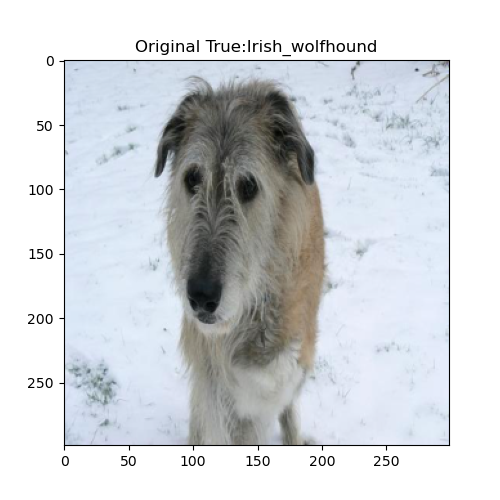

In [3]:
imshow(images[idx:idx+1], title="Original True:%s"%(idx2label[labels[idx:idx+1].item()])) # 原始图片

# 非目标白盒攻击

针对目标识别模型，设计非目标白盒攻击，使用 FGSM、PGD 和 DeepFool 实现为图像生成对抗攻击样本，并分析改变扰动 𝜖 的大小对对抗图像可视性和攻击成功率。要求：给出攻击前和攻击后的图片，并给出攻击效果。

## FGSM

FGSM attack: original label Irish_wolfhound  pred label quill


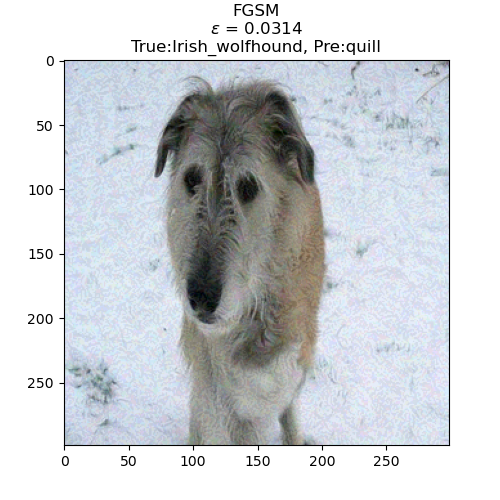

In [4]:
import matplotlib.pyplot as plt
def fgsm_attack(e=8/255):
    # 避免报错：RuntimeError: expected scalar type Double but found Float，添加参数e
    atk = torchattacks.FGSM(model, eps=e) # atk 表示攻击方法
    # fgsm_image 是攻击后生成的图片集。由于DeepFool等的攻击的时间较长，所以只取一张图片(idx)进行攻击
    fgsm_image = atk(images[idx:idx+1], labels[idx:idx+1])
    fgsm_pre = get_pred(model, fgsm_image[0:1], device) # 获取攻击后图片预测的标签。只攻击了部分图片，故图片index不为[idx:idx+1]
    print("FGSM attack: original label", idx2label[labels[idx:idx+1].item()], " pred label", idx2label[fgsm_pre.item()])
    imshow(fgsm_image[0:1], title="FGSM\n" + r"$\epsilon$ = %.4f" % e + "\nTrue:%s, Pre:%s" % (
        idx2label[labels[idx:idx + 1].item()], idx2label[fgsm_pre.item()]))  # 攻击后的图片

fgsm_attack(e=8/255) # fgsm-attacked-default

### 分析

eps: 0.0 correct: 15 total: 25 accuracy: 0.6
eps: 0.0003 correct: 11 total: 25 accuracy: 0.44
eps: 0.0006 correct: 5 total: 25 accuracy: 0.2
eps: 0.0009 correct: 3 total: 25 accuracy: 0.12
eps: 0.0012 correct: 3 total: 25 accuracy: 0.12
eps: 0.0015 correct: 2 total: 25 accuracy: 0.08
eps: 0.0018 correct: 2 total: 25 accuracy: 0.08
eps: 0.0021 correct: 1 total: 25 accuracy: 0.04
eps: 0.0024 correct: 1 total: 25 accuracy: 0.04
eps: 0.0027 correct: 0 total: 25 accuracy: 0.0
eps: 0.003 correct: 0 total: 25 accuracy: 0.0


C:\Users\littlezhu\AppData\Local\Temp\ipykernel_1180\3072014256.py:25: RuntimeWarning: invalid value encountered in divide
  plt.plot(eps_list, np.array(correct) / np.array(total), marker= '^')


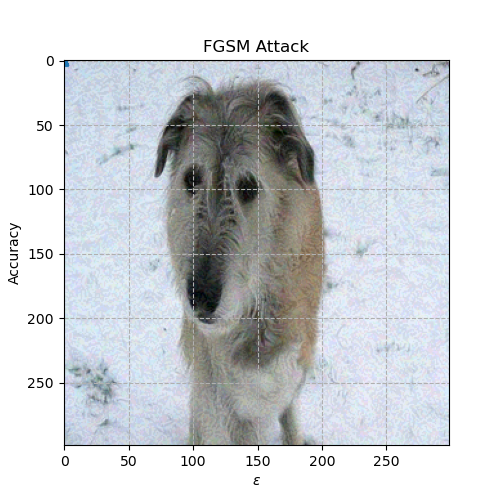

In [5]:
# 分析改变扰动 𝜖 的大小对对抗图像可视性和攻击成功率。
def fgsm_attack_analysis(start=0.00, end=1.00, step=0.01):
    eps_num = int((end - start) / step + 2) # 计算 𝜖 取值个数 + 1
    correct = [0 for i in range(eps_num)] # 预测正确的图片数
    total = [0 for i in range(eps_num)] # 总共的图片数
    eps_list = [0 for i in range(eps_num)] # 扰动的大小
    for i, e in enumerate(np.arange(start, end + 1, step)):
        e = float(Decimal(str(e)).quantize(Decimal('0.0000')))
        eps_list[i] = e if e <= end else end
        atk = torchattacks.FGSM(model, eps=eps_list[i])
        fgsm_image = atk(images, labels)
        for idx in range(len(images)):
            fgsm_pre = get_pred(model, fgsm_image[idx:idx+1], device)
            # print("FGSM attack: original label", idx2label[labels[idx:idx + 1].item()], " pred label", idx2label[fgsm_pre.item()])
            # imshow(fgsm_image[idx:idx+1], title="FGSM True:%s, Pre:%s"%(idx2label[labels[idx:idx+1].item()], idx2label[fgsm_pre.item()]))
            # if idx == 0:
            #     imshow(fgsm_image[idx:idx+1], title="FGSM True:%s, Pre:%s"%(idx2label[labels[idx:idx+1].item()], idx2label[fgsm_pre.item()]))
            if idx2label[labels[idx:idx+1].item()] == idx2label[fgsm_pre.item()]:
                correct[i] += 1
            total[i] += 1
        print("eps:", eps_list[i], "correct:", correct[i], "total:", total[i], "accuracy:", correct[i]/total[i])
        if eps_list[i] == end:
            break
    # 将攻击成功率绘制成图像
    plt.plot(eps_list, np.array(correct) / np.array(total), marker= '^')
    plt.grid(ls='--')
    plt.title("FGSM Attack")
    plt.xlabel(r'$\epsilon$')
    plt.ylabel("Accuracy")
    # 保存到"../img/"中
    plt.savefig("../img/fgsm-analysis.png")
    plt.show()

fgsm_attack_analysis(start=0, end=0.003, step=0.0003)

## PGD

In [6]:
# PGD attack
def pgd_attack(e=8/255, a=2/225, s=10, rand_start=True):
    atk = torchattacks.PGD(model, eps=e, alpha=a, steps=s, random_start=rand_start)
    pgd_image = atk(images[idx:idx+1], labels[idx:idx+1])
    pgd_pre = get_pred(model, pgd_image[0:1], device)
    print("PGD attack: original label", idx2label[labels[idx:idx+1].item()], " pred label", idx2label[pgd_pre.item()])
    imshow(pgd_image[0:1], title="PGD\n" + r"$\epsilon$ = %.4f" % e + "\nTrue:%s, Pre:%s" % (
        idx2label[labels[idx:idx + 1].item()], idx2label[pgd_pre.item()]))

pgd_attack(e=8/255) # pgd-attacked-default

### 分析

In [ ]:
def pgd_attack_analysis(start=0.00, end=1.00, step=0.01):
    eps_num = int((end - start) / step + 2)
    correct = [0 for i in range(eps_num)]
    total = [0 for i in range(eps_num)]
    eps_list = [0 for i in range(eps_num)]
    for i, e in enumerate(np.arange(start, end + 1, step)):
        e = float(Decimal(str(e)).quantize(Decimal('0.0000')))
        eps_list[i] = e if e <= end else end
        atk = torchattacks.PGD(model, eps=eps_list[i], alpha=2/225, steps=10, random_start=True)
        pgd_image = atk(images, labels)
        for idx in range(len(images)):
            pgd_pre = get_pred(model, pgd_image[idx:idx+1], device)
            # print("PGD attack: original label", idx2label[labels[idx:idx + 1].item()], " pred label", idx2label[pgd_pre.item()])
            # imshow(pgd_image[idx:idx+1], title="PGD True:%s, Pre:%s"%(idx2label[labels[idx:idx+1].item()], idx2label[pgd_pre.item()]))
            # if idx == 0:
            #     imshow(pgd_image[idx:idx+1], title="PGD True:%s, Pre:%s"%(idx2label[labels[idx:idx+1].item()], idx2label[pgd_pre.item()]))
            if idx2label[labels[idx:idx+1].item()] == idx2label[pgd_pre.item()]:
                correct[i] += 1
            total[i] += 1
        print("eps:", eps_list[i], "correct:", correct[i], "total:", total[i], "accuracy:", correct[i]/total[i])
        if eps_list[i] == end:
            break
    plt.plot(eps_list, np.array(correct) / np.array(total), marker= '^')
    plt.grid(ls='--')
    plt.title("PGD Attack")
    plt.xlabel(r'$\epsilon$')
    plt.ylabel("Accuracy")
    plt.savefig("../img/pgd-analysis.png")
    plt.show()

pgd_attack_analysis(start=0, end=0.0028, step=0.0003)

## DeepFool

In [ ]:
# DeepFool attack
def deepfool_attack(s=50, o=0.20):
    atk = torchattacks.DeepFool(model, steps=s, overshoot=o)
    deepfool_image = atk(images[idx:idx+1], labels[idx:idx+1])
    deepfool_pre = get_pred(model, deepfool_image[0:1], device)
    print("DeepFool attack: original label", idx2label[labels[idx:idx+1].item()], " pred label", idx2label[deepfool_pre.item()])
    imshow(deepfool_image[0:1], title="DeepFool\nsteps = %d, overshoot = %.2f" % (s, o)+ "\nTrue:%s, Pre:%s" % (
        idx2label[labels[idx:idx + 1].item()], idx2label[deepfool_pre.item()]))

deepfool_attack(s=50, o=0.20) # deepfool-attacked-default

### 分析

In [ ]:
def deepfool_attack_analysis(start=0, end=50, step=1):
    steps_num = int((end - start) / step + 2)
    correct = [0 for i in range(steps_num)]
    total = [0 for i in range(steps_num)]
    steps_list = [0 for i in range(steps_num)]
    for i, s in enumerate(np.arange(start, end + 1, step)):
        steps_list[i] = s if s <= end else end
        atk = torchattacks.DeepFool(model, steps=s, overshoot=0.20)
        deepfool_image = atk(images, labels)
        for idx in range(len(images)):
            deepfool_pre = get_pred(model, deepfool_image[idx:idx+1], device)
            # print("DeepFool attack: original label", idx2label[labels[idx:idx + 1].item()], " pred label", idx2label[deepfool_pre.item()])
            # imshow(deepfool_image[idx:idx+1], title="DeepFool True:%s, Pre:%s"%(idx2label[labels[idx:idx+1].item()], idx2label[deepfool_pre.item()]))
            # if idx == 0:
            #     imshow(deepfool_image[idx:idx+1], title="DeepFool True:%s, Pre:%s"%(idx2label[labels[idx:idx+1].item()], idx2label[deepfool_pre.item()]))
            if idx2label[labels[idx:idx+1].item()] == idx2label[deepfool_pre.item()]:
                correct[i] += 1
            total[i] += 1
        print("steps:", steps_list[i], "correct:", correct[i], "total:", total[i], "accuracy:", correct[i]/total[i])
        if steps_list[i] == end:
            break
    plt.plot(steps_list, np.array(correct) / np.array(total), marker= '^')
    plt.grid(ls='--')
    plt.title("DeepFool Attack")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.savefig("../img/deepfool-analysis.png")
    plt.show()

deepfool_attack_analysis(start=0, end=4, step=1)

# 目标白盒攻击

针对目标识别模型，设计目标白盒攻击，通过使用 FGSM、JSMA、PGD 等实现目标对抗攻击，使得模型将图片识别为某一个固定标签，并分析改变扰动 𝜖 的大小对对抗图像可视性和攻击成功率。
要求：给出攻击前和攻击后的图片，并给出攻击效果。

## FGSM

In [ ]:
# FGSM targeted attack
def fgsm_targeted_attack(e=8/255, offset=49):
    atk = torchattacks.FGSM(model, eps=e)
    atk.set_mode_targeted_by_label(quiet=True)
    # 攻击目标为offset，默认为49，即African_crocodile，非洲鳄鱼
    target_labels = labels - labels + offset
    fgsm_targeted_image = atk(images[idx:idx + 1], target_labels[idx:idx + 1])
    fgsm_targeted_pre = get_pred(model, fgsm_targeted_image[0:1], device)
    print("FGSM targeted attack: original label", idx2label[labels[idx:idx+1].item()], " pred label", idx2label[fgsm_targeted_pre.item()])
    imshow(fgsm_targeted_image[0:1], title="FGSM targeted\n" + r"$\epsilon$ = %.4f" % e + "\nTrue:%s, Pre:%s" % (
        idx2label[labels[idx:idx + 1].item()], idx2label[fgsm_targeted_pre.item()]))

fgsm_targeted_attack() # fgsm-targeted-attacked-default

### 分析

In [ ]:
def fgsm_targeted_attack_accuracy(start=0.00, end=0.06, step=0.004, offset=49):
    eps_num = int((end - start) / step + 2)
    eps_list = [0 for i in range(eps_num)]
    total = [0 for i in range(eps_num)]
    accurate = [0 for i in range(eps_num)]
    for i, e in enumerate(np.arange(start, end + 1, step)):
        e = float(Decimal(str(e)).quantize(Decimal('0.0000')))
        eps_list[i] = e if e <= end else end
        atk = torchattacks.FGSM(model, eps=eps_list[i])
        atk.set_mode_targeted_by_label(quiet=True)
        target_labels = labels - labels + offset
        for idx in range(len(images)):
            fgsm_targeted_image = atk(images[idx:idx + 1], target_labels[idx:idx + 1])
            fgsm_targeted_pre = get_pred(model, fgsm_targeted_image[0:1], device)
            # print("FGSM targeted attack: original label", idx2label[labels[idx:idx+1].item()], " pred label", idx2label[fgsm_targeted_pre.item()])
            if idx2label[target_labels[idx:idx + 1].item()] == idx2label[fgsm_targeted_pre.item()]:
                accurate[i] += 1
            total[i] += 1
        print("eps:", eps_list[i], "correct:", accurate[i], "total:", total[i], "accuracy:", accurate[i]/24)
        if eps_list[i] == end:
            break
    plt.plot(eps_list, np.array(accurate) / np.array(total), marker= '^')
    plt.grid(ls='--')
    plt.title("FGSM Targeted Attack")
    plt.xlabel(r"$\epsilon$")
    plt.ylabel("Accuracy")
    plt.savefig("../img/fgsm-targeted-attack-accuracy.png")
    plt.show()

fgsm_targeted_attack_accuracy() # fgsm-targeted-attack-accuracy

## JSMA

In [ ]:
# JSMA targeted attack
def jsma_targeted_attack(t=1.0, g=0.1, offset=49):
    atk = torchattacks.JSMA(model, theta=t, gamma=g)
    atk.set_mode_targeted_by_label(quiet=True)
    target_labels = labels - labels + offset
    jsma_targeted_image = atk(images[idx:idx + 1], target_labels[idx:idx + 1])
    jsma_targeted_pre = get_pred(model, jsma_targeted_image[0:1], device)
    print("JSMA targeted attack: original label", idx2label[labels[idx:idx+1].item()], " pred label", idx2label[jsma_targeted_pre.item()])
    imshow(jsma_targeted_image[0:1], title="JSMA targeted\n" + r"$\theta$ = %.4f, $\gamma$ = %.4f" % (t, g) + "\nTrue:%s, Pre:%s" % (
        idx2label[labels[idx:idx + 1].item()], idx2label[jsma_targeted_pre.item()]))

jsma_targeted_attack() # jsma-targeted-attacked-default

### 分析

In [ ]:
def jsma_targeted_attack_accuracy(start=0.00, end=0.06, step=0.004, offset=49):
    theta_num = int((end - start) / step + 2)
    theta_list = [0 for i in range(theta_num)]
    total = [0 for i in range(theta_num)]
    accurate = [0 for i in range(theta_num)]
    for i, t in enumerate(np.arange(start, end + 1, step)):
        t = float(Decimal(str(t)).quantize(Decimal('0.0000')))
        theta_list[i] = t if t <= end else end
        atk = torchattacks.JSMA(model, theta=theta_list[i])
        atk.set_mode_targeted_by_label(quiet=True)
        target_labels = labels - labels + offset
        for idx in range(len(images)):
            jsma_targeted_image = atk(images[idx:idx + 1], target_labels[idx:idx + 1])
            jsma_targeted_pre = get_pred(model, jsma_targeted_image[0:1], device)
            # print("JSMA targeted attack: original label", idx2label[labels[idx:idx+1].item()], " pred label", idx2label[jsma_targeted_pre.item()])
            if idx2label[target_labels[idx:idx + 1].item()] == idx2label[jsma_targeted_pre.item()]:
                accurate[i] += 1
            total[i] += 1
        print("theta:", theta_list[i], "correct:", accurate[i], "total:", total[i], "accuracy:", accurate[i]/24)
        if theta_list[i] == end:
            break
    plt.plot(theta_list, np.array(accurate) / np.array(total), marker= '^')
    plt.grid(ls='--')
    plt.title("JSMA Targeted Attack")
    plt.xlabel(r"$\theta$")
    plt.ylabel("Accuracy")
    plt.savefig("../img/jsma-targeted-attack-accuracy.png")
    plt.show()

jsma_targeted_attack_accuracy() # jsma-targeted-attack-accuracy

## PGD

In [ ]:
# PGD targeted attack
def pgd_targeted_attack(e=8/255, offset=49, a=2/225, s=10, rand_start=True):
    atk = torchattacks.PGD(model, eps=e, alpha=a, steps=s, random_start=rand_start)
    atk.set_mode_targeted_by_label(quiet=True)
    target_labels = labels - labels + offset
    pgd_targeted_image = atk(images[idx:idx + 1], target_labels[idx:idx + 1])
    pgd_targeted_pre = get_pred(model, pgd_targeted_image[0:1], device)
    print("PGD targeted attack: original label", idx2label[labels[idx:idx+1].item()], " pred label", idx2label[pgd_targeted_pre.item()])
    imshow(pgd_targeted_image[0:1], title="PGD targeted\n" + r"$\epsilon$ = %.4f" % e + "\nTrue:%s, Pre:%s" % (
        idx2label[labels[idx:idx + 1].item()], idx2label[pgd_targeted_pre.item()]))

pgd_targeted_attack() # pgd-targeted-attacked-default

### 分析

In [ ]:
# PGD targeted attack accuracy
def pgd_targeted_attack_accuracy(start=0.00, end=0.06, step=0.004, offset=49, a=2/225, s=10, rand_start=True):
    eps_num = int((end - start) / step + 2)
    eps_list = [0 for i in range(eps_num)]
    total = [0 for i in range(eps_num)]
    accurate = [0 for i in range(eps_num)]
    for i, e in enumerate(np.arange(start, end + 1, step)):
        e = float(Decimal(str(e)).quantize(Decimal('0.0000')))
        eps_list[i] = e if e <= end else end
        atk = torchattacks.PGD(model, eps=eps_list[i], alpha=a, steps=s, random_start=rand_start)
        atk.set_mode_targeted_by_label(quiet=True)
        target_labels = labels - labels + offset
        for idx in range(len(images)):
            pgd_targeted_image = atk(images[idx:idx + 1], target_labels[idx:idx + 1])
            pgd_targeted_pre = get_pred(model, pgd_targeted_image[0:1], device)
            # print("PGD targeted attack: original label", idx2label[labels[idx:idx+1].item()], " pred label", idx2label[pgd_targeted_pre.item()])
            if idx2label[target_labels[idx:idx + 1].item()] == idx2label[pgd_targeted_pre.item()]:
                accurate[i] += 1
            total[i] += 1
        print("eps:", eps_list[i], "correct:", accurate[i], "total:", total[i], "accuracy:", accurate[i]/24)
        if eps_list[i] == end:
            break
    plt.plot(eps_list, np.array(accurate) / np.array(total), marker= '^')
    plt.grid(ls='--')
    plt.title("PGD Targeted Attack")
    plt.xlabel(r"$\epsilon$")
    plt.ylabel("Accuracy")
    plt.savefig("../img/pgd-targeted-attack-accuracy.png")
    plt.show()

pgd_targeted_attack_accuracy(start=0.00, end=0.12, step=0.008) # pgd-targeted-attack-accuracy

# 现实图片攻击

自己拍摄一张图片后，利用对抗样本攻击生成对抗图像，给出攻击前后的图片和攻击效果。

In [ ]:
# FGSM targeted attack to my photograph
def fgsm_targeted_attack_to_myphoto(e=8/255, offset=49):
    myphoto_pre = get_pred(model, images[0:1], device) # 识别自己的照片，n01582220/n01582220_0001.JPEG
    atk = torchattacks.FGSM(model, eps=e)
    # 设定目标标签为"African_crocodile"
    atk.set_mode_targeted_by_label(quiet=True)
    target_labels = labels - labels + offset
    fgsm_targeted_image = atk(images[0:1], target_labels[0:1])
    fgsm_targeted_pre = get_pred(model, fgsm_targeted_image[0:1], device)
    print("FGSM targeted attack: original label", idx2label[myphoto_pre.item()], " pred label", idx2label[fgsm_targeted_pre.item()])
    imshow(images[0:1], title="Original\nTrue: %s" % (idx2label[myphoto_pre.item()]))
    imshow(fgsm_targeted_image[0:1], title="FGSM targeted\nTrue: %s, Pre: %s" % (
        idx2label[myphoto_pre.item()], idx2label[fgsm_targeted_pre.item()]))

# fgsm_targeted_attack_to_myphoto(e=0.012) # 由先前的分析知，FGSM攻击的epsilon取0.012时，攻击效果最好
# myphoto-original  myphoto-fgsm-targeted